<a href="https://colab.research.google.com/github/Dennis-fast-ai/newtest/blob/main/Animal_Identifierv1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastcore --upgrade --use-feature=2020-resolver

In [ ]:
#hide
#!pip install fastai --upgrade --use-feature=2020-resolver
!pip install fastbook
!import fastbook
!fastbook.setup_book()

In [ ]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [ ]:
from fastai.vision.all import *

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner

Pathlib ... 

Mount gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/projects/animals/"
base_dir = root_dir + 'animals'

Mounted at /content/gdrive


Define Path and check

In [ ]:
animal_types = 'impala', 'springbok'
path = Path("/content/gdrive/My Drive/Colab Notebooks/projects/animals/")

In [ ]:
fns = get_image_files(path)
fns

(#221) [Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000000.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000001.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000002.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000004.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000005.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000006.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000008.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000010.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000012.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/projects/animals/impala/00000013.jpg')...]

Verify images and unlink any that failed

In [ ]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
failed.map(Path.unlink)

(#0) []

Define Dataloggers

In [ ]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

Block and split data for easier manipulation later

In [ ]:
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Define Datalogers path and check it is valid

In [ ]:
dls = animals.dataloaders(path)

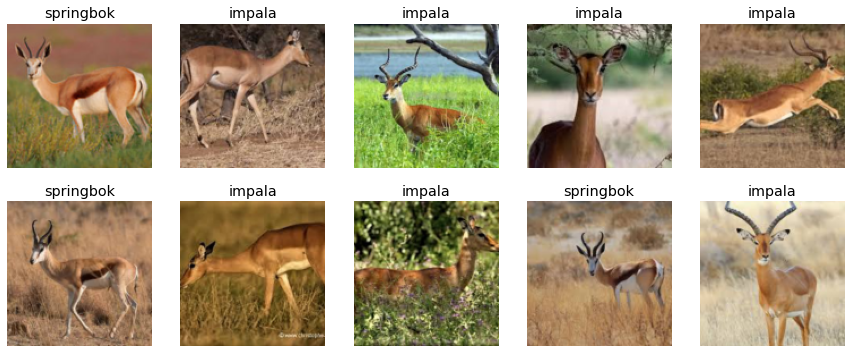

In [ ]:
dls.valid.show_batch(max_n=10, nrows=2)

Resize the images to fit the required size and define the dls path

In [ ]:
animals = animals.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = animals.dataloaders(path)
dls.vocab

['impala', 'springbok']

Take a sample and evaluate the learning rate v loss to help establish the fit parameters

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


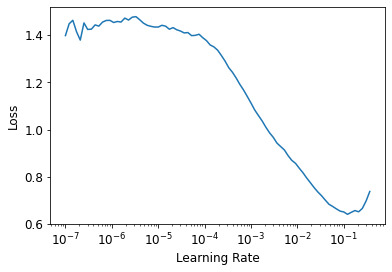

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

Evalueat the fit through one cycle look for best fit epochs v learning rate (use the graph above and optimise)

In [ ]:
learn.fit_one_cycle(12, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,1.032210,0.612927,0.409091,00:03
1,0.878418,0.650700,0.431818,00:03
2,0.811990,0.721036,0.454545,00:03
3,0.803951,0.881265,0.500000,00:03
4,0.835749,0.967773,0.500000,00:03
5,0.835858,0.804528,0.522727,00:03
6,0.810286,0.750750,0.454545,00:03
7,0.801749,0.724660,0.363636,00:03
8,0.790673,0.711357,0.340909,00:03
9,0.777926,0.685726,0.295455,00:03


Use a Confusion Plot to evaluate the number of images that were not identifiable and or confused

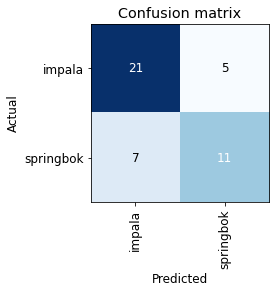

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Unfreese the full sets and apply fit limits to optimise learning

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(2e-2,2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.701382,0.647049,0.295455,00:03
1,0.757858,0.642905,0.295455,00:03
2,0.750858,0.636917,0.318182,00:03
3,0.741327,0.631550,0.272727,00:03
4,0.842701,0.639434,0.272727,00:03
5,0.851864,0.645126,0.295455,00:03
6,0.833592,0.648059,0.250000,00:03
7,0.811200,0.661390,0.272727,00:03
8,0.793742,0.659780,0.272727,00:03
9,0.775291,0.661698,0.272727,00:03


USe the Confusion Plot to evaluate the number of confused images v certain images

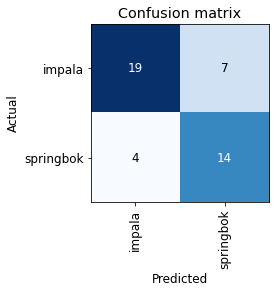

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

View the confused images

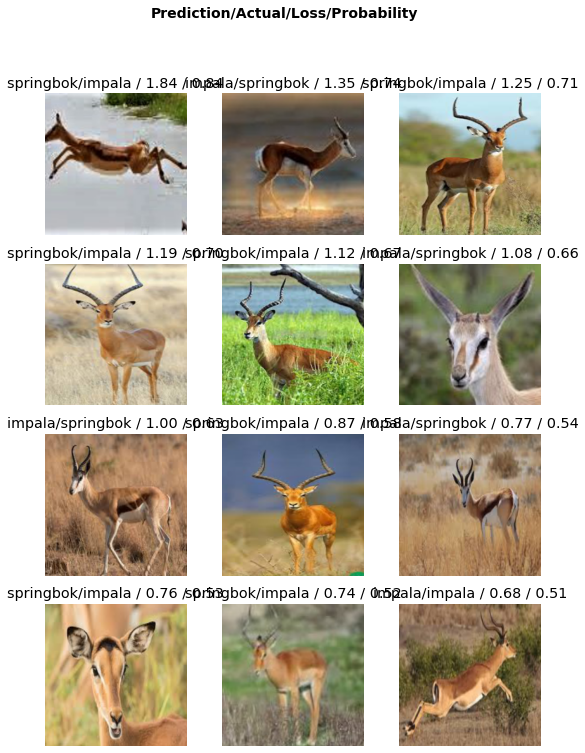

In [ ]:
interp.plot_top_losses(12, nrows=4)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner